<h1> Statistical Data Analysis

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn import metrics

In [60]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [61]:
from sklearn.tree import export_graphviz

In [9]:
## Importing csv files into panda DataFrames

In [10]:
NFLCleanCSV = '/Users/Rezalution/NFLClean.csv'

In [78]:
NFLClean = pd.read_csv(NFLCleanCSV,encoding ='latin1')

In [79]:
NFLClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11878 entries, 0 to 11877
Data columns (total 12 columns):
Unnamed: 0                    11878 non-null int64
homeWin                       11878 non-null int64
AwayWin                       11878 non-null int64
schedule_season               11878 non-null int64
stadium_type                  11673 non-null object
weather_temperature           11878 non-null float64
weather_temperatureRounded    11878 non-null float64
weather_humidity              8388 non-null object
weather_wind_mph              11878 non-null float64
score_home                    11878 non-null float64
score_away                    11878 non-null float64
scoreDiff                     11878 non-null float64
dtypes: float64(6), int64(4), object(2)
memory usage: 1.1+ MB


In [80]:
NFLClean['weather_humidity'] = NFLClean['weather_humidity'].astype(str).str.extract('(\d+)').astype(float)

In [81]:
NFLClean = NFLClean.drop(columns=['Unnamed: 0','stadium_type','schedule_season','weather_temperatureRounded','AwayWin','score_home','score_away','scoreDiff'])

In [82]:
NFLClean = NFLClean.dropna(axis=0,subset=['weather_humidity'])

In [83]:
NFLClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8388 entries, 0 to 10541
Data columns (total 4 columns):
homeWin                8388 non-null int64
weather_temperature    8388 non-null float64
weather_humidity       8388 non-null float64
weather_wind_mph       8388 non-null float64
dtypes: float64(3), int64(1)
memory usage: 327.7 KB


In [84]:
labels = np.array(NFLClean['homeWin'])

In [85]:
NFLCleanFeatures = NFLClean.drop(columns=['homeWin'])

In [86]:
NFLCleanFeatures.head()

,weather_temperature,weather_humidity,weather_wind_mph
0,83.0,71.0,6.0
1,81.0,70.0,7.0
2,70.0,82.0,7.0
3,82.0,78.0,11.0
4,64.0,62.0,8.0


In [87]:
feature_list = list(NFLCleanFeatures.columns)

In [88]:
features = np.array(NFLCleanFeatures)

In [89]:
## Train

In [90]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.3, random_state = 42)

In [91]:
## Train Model

In [120]:
rf = RandomForestClassifier(n_estimators=10000, random_state=42, max_features = 'sqrt')

In [121]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [122]:
n_nodes = []
max_depths = []

In [123]:
for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

In [124]:
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 4071
Average maximum depth 32


In [125]:
train_rf_predictions = rf.predict(X_train)
train_rf_probs = rf.predict_proba(X_train)[:, 1]

In [126]:
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [127]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

Recall Baseline: 1.0 Test: 0.64 Train: 0.98
Precision Baseline: 0.57 Test: 0.57 Train: 0.96
Roc Baseline: 0.5 Test: 0.5 Train: 1.0


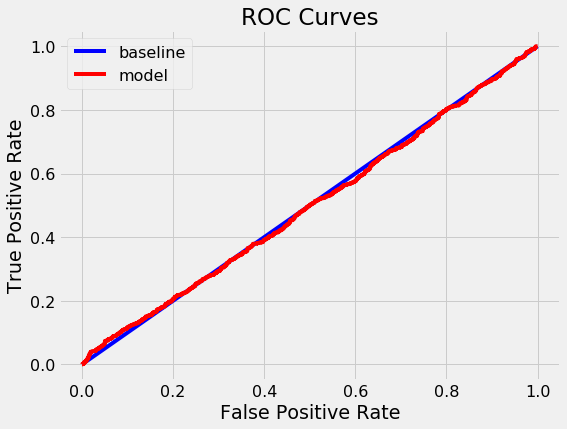

<Figure size 432x288 with 0 Axes>

In [128]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')


In [129]:
## Predict

In [130]:
y_pred = rf.predict(X_test)

In [135]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5168851807707588


In [136]:
## See the importance of each featue

In [132]:
feature_imp = pd.Series(rf.feature_importances_,index=feature_list)

In [137]:
feature_imp

weather_temperature    0.418782
weather_humidity       0.406218
weather_wind_mph       0.175000
dtype: float64

This shows that wind has the least importance of the three. In the next run I will remove it from the features list.

In [138]:
## Test the outcome of a given set of values

In [134]:
rf.predict([[100,100,0]])

array([0])

### Without Wind as a feature

In [33]:
X = NFLClean.drop(columns=['weather_wind_mph'])

In [34]:
labels = np.array(X['homeWin'])

In [35]:
X = X.drop(columns=['homeWin'])

In [36]:
features2 = np.array(X)

In [37]:
feature_list2 = list(X.columns)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features2, labels, test_size= 0.3, random_state = 42)

In [39]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42, max_features = 'sqrt')

In [40]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [41]:
y_pred = rf.predict(X_test)

In [42]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5188716726261422


In [43]:
feature_imp = pd.Series(rf.feature_importances_,index=feature_list2)

In [44]:
feature_imp

weather_temperature    0.496822
weather_humidity       0.503178
dtype: float64

## Only Temperature as a feature

In [45]:
NFLClean = pd.read_csv(NFLCleanCSV,encoding ='latin1')

In [46]:
NFLClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11878 entries, 0 to 11877
Data columns (total 12 columns):
Unnamed: 0                    11878 non-null int64
homeWin                       11878 non-null int64
AwayWin                       11878 non-null int64
schedule_season               11878 non-null int64
stadium_type                  11673 non-null object
weather_temperature           11878 non-null float64
weather_temperatureRounded    11878 non-null float64
weather_humidity              8388 non-null object
weather_wind_mph              11878 non-null float64
score_home                    11878 non-null float64
score_away                    11878 non-null float64
scoreDiff                     11878 non-null float64
dtypes: float64(6), int64(4), object(2)
memory usage: 1.1+ MB


In [47]:
NFLClean = NFLClean.drop(columns=['Unnamed: 0','stadium_type','schedule_season','weather_temperatureRounded','weather_humidity','weather_wind_mph','AwayWin','score_home','score_away','scoreDiff'])

In [48]:
NFLClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11878 entries, 0 to 11877
Data columns (total 2 columns):
homeWin                11878 non-null int64
weather_temperature    11878 non-null float64
dtypes: float64(1), int64(1)
memory usage: 185.7 KB


In [49]:
labels = np.array(NFLClean['homeWin'])

In [50]:
NFLCleanFeatures = NFLClean.drop(columns=['homeWin'])

In [51]:
feature_list = list(NFLCleanFeatures.columns)

In [52]:
features = np.array(NFLCleanFeatures)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.3, random_state = 42)

In [54]:
rf = RandomForestClassifier(n_estimators=10000, random_state=42)

In [55]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
y_pred = rf.predict(X_test)

In [57]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5735129068462402


In [58]:
y_pred = rf.predict(X_train)

In [59]:
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))

Accuracy: 0.5727688236709165


This had the best results of the 3 runs. Though it is still a low score. 

# Conclusion

After run all three models, I can conclude that weather does not significantly effect the outcome of an NFL game. All three models had low prediction scores which indicts that there is no real correlation between the outcome of a game and weather conditions. If there was a correlation the model would be able to use the features to accurately predict the outcome. The prediction score would be alot higher than the ones received. This also correlates to what I found in the statistical anaylsis that showed low correlation scores between winning score and the weather.